In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# EarthQuake Prediction

*Written by Daniele Rege Cambrin*

## Introduction

## Environment

For the environment, we will install the torchgeo and scikit-learn packages.

In [2]:
%pip install torchgeo h5py scikit-learn

## Imports

In [3]:
import torchgeo
from torchgeo.datamodules import QuakeSetDataModule
from torchgeo.models import resnet50, ResNet50_Weights
from torchgeo.trainers import ClassificationTask
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from pathlib import Path
import tempfile
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain
import h5py
from tqdm import tqdm
import numpy as np
from collections import defaultdict

## Dataset

The dataset we will use is the QuakeSet dataset [1] (licensed under OpenRAIL License), which has patches from different parts of the world before and after earthquake, with corresponding negative examples (Figure below). The dataset uses SAR imagery from Sentinel-1 satellite with 10m of spatial resolution. The task is predicting for each couple of images if an earthquake occurred between them.

[1] Rege Cambrin, D., & Garza, P. (2024). QuakeSet: A Dataset and Low-Resource Models to Monitor Earthquakes through Sentinel-1. Proceedings of the International ISCRAM Conference. doi:10.59297/n89yc374

In [4]:
# The datamodule is already implemented in torchgeo, so we can just use it
datamodule = QuakeSetDataModule(batch_size=16, num_workers=1, download=True)
# This will download the dataset
datamodule.prepare_data()

100%|██████████| 9.67G/9.67G [00:58<00:00, 166MB/s] 


# Batch Visualization

The QuakeSetDataModule has already a ```plot``` function implemented to show the samples.

Remember to call ```setup``` before using it with *fit* or *validate* (otherwise you will get an error).

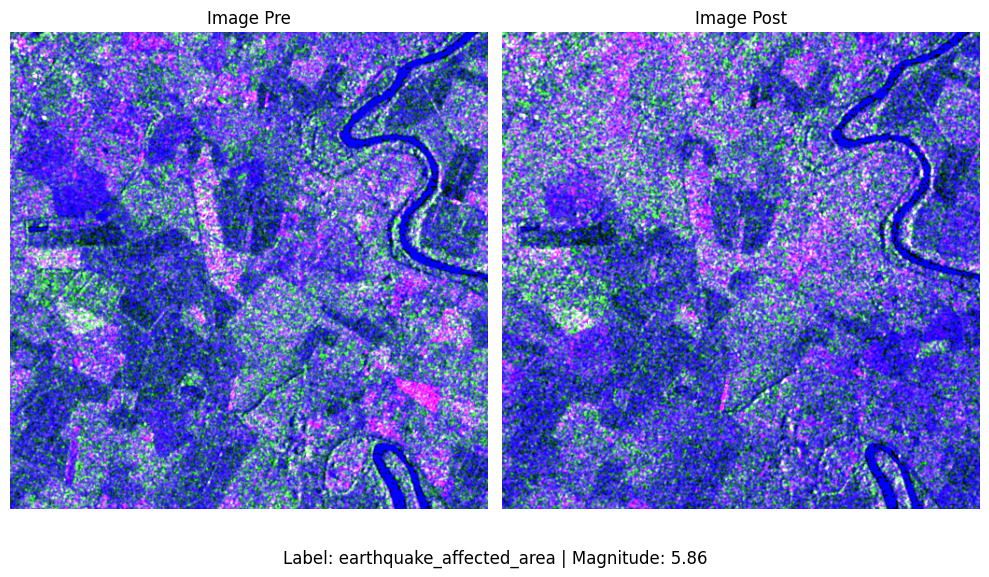

In [5]:
datamodule.setup("fit")
datamodule.setup("test")
sample = datamodule.val_dataset[500]
fig = datamodule.plot(sample)

# Training

The first approach is using a pretrained model to compute the embeddings to be used from a classical machine learning model.

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Change to "cpu" if you don't have a GPU

In [7]:
model_transform = ResNet50_Weights.SENTINEL1_ALL_MOCO.transforms
rn_model = resnet50(ResNet50_Weights.SENTINEL1_ALL_MOCO).to(DEVICE).eval()

Downloading: "https://hf.co/torchgeo/resnet50_sentinel1_all_moco/resolve/e79862c667853c10a709bdd77ea8ffbad0e0f1cf/resnet50_sentinel1_all_moco-906e4356.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel1_all_moco-906e4356.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 193MB/s]


In [8]:
# Open a HDF5 file in write mode
with h5py.File("data/embeddings.h5", "w") as f:
    # Iterate over the batches in both the training and validation dataloaders
    for i, (batch, split) in tqdm(enumerate(
            chain(
                zip(datamodule.train_dataloader(), ["train"] * len(datamodule.train_dataloader())),
                zip(datamodule.val_dataloader(), ["val"] * len(datamodule.val_dataloader())),
                zip(datamodule.test_dataloader(), ["test"] * len(datamodule.test_dataloader())),
            )
        )):
        # Prepare the data for inference
        img = batch["image"].to(DEVICE)
        labels = batch["label"]
        pre = model_transform({"image": img[:, :2]})["image"]
        post = model_transform({"image": img[:, 2:]})["image"]
        # Do the inference and save the embeddings to the HDF5 file
        with torch.no_grad():
            embs = torch.concat([rn_model(pre), rn_model(post)], axis=1).cpu().numpy()
        for j, (emb, lab) in enumerate(zip(embs, labels)):
            f.create_dataset(f"{split}/{i}_{j}", data=emb, compression="gzip")
            f[f"{split}/{i}_{j}"].attrs["label"] = lab

209it [03:07,  1.11it/s]


In [9]:
# Load the embeddings and labels of the train split into memory
with h5py.File("data/embeddings.h5", "r") as f:
    embeddings = defaultdict(list)
    labels = defaultdict(list)
    for split in ["train", "val", "test"]:
        for key in f[split]:
            embeddings[split].append(f[split][key][...])
            labels[split].append(f[split][key].attrs["label"])
        embeddings[split] = np.stack(embeddings[split])
        labels[split] = np.array(labels[split])

# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(embeddings["train"], labels["train"])

# Evaluate the classifier
preds = clf.predict(embeddings["test"])
print(classification_report(labels["test"], preds))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       233
           1       0.86      0.72      0.78       278

    accuracy                           0.78       511
   macro avg       0.79      0.79      0.78       511
weighted avg       0.80      0.78      0.78       511



The second approach requires training a network from scratch. To this end, we can use the TorchGeo's ```ClassificationTask``` and Lightning's ```Trainer``` to simplify the training.

In [10]:
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
default_root_dir = Path(tempfile.gettempdir()) / 'experiments'
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', dirpath=default_root_dir, save_top_k=1, save_last=True
)
logger = CSVLogger(save_dir=default_root_dir, name='tutorial_logs')

In [11]:
task = ClassificationTask(model="resnet18", in_channels=4, num_classes=2, loss="ce", lr=0.0001)

In [12]:
trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
    logger=logger,
    min_epochs=1,
    max_epochs=5,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model=task, datamodule=datamodule)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /tmp/experiments exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.723    Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
trainer.test(model=task, datamodule=datamodule, ckpt_path=checkpoint_callback.best_model_path)

INFO: Restoring states from the checkpoint path at /tmp/experiments/epoch=0-step=142.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /tmp/experiments/epoch=0-step=142.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /tmp/experiments/epoch=0-step=142.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /tmp/experiments/epoch=0-step=142.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.7198953628540039     │
│       test_F1Score        │     0.698630154132843     │
│     test_JaccardIndex     │    0.5280036330223083     │
│   test_OverallAccuracy    │     0.698630154132843     │
│         test_loss         │     0.548475444316864     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.548475444316864,
  'test_AverageAccuracy': 0.7198953628540039,
  'test_F1Score': 0.698630154132843,
  'test_JaccardIndex': 0.5280036330223083,
  'test_OverallAccuracy': 0.698630154132843}]